# DTFE

In [1]:
#Load the numpy and scipy libraries
import numpy as np
from scipy.spatial import Delaunay
import numba
from numba import float32, float64, int64
from typing import Union


@numba.jit(nopython=True, nogil=True)
def triangle_area(sim: int64[:], points: float64[:,:]):
    return abs(np.linalg.det(np.stack((points[sim[1]] - points[sim[0]], 
                                       points[sim[2]] - points[sim[0]])))) / 2


@numba.jit(nopython=True, nogil=True)
def compute_densities(pts: float64[:,:], simps: float64[:,:],
                      m: Union[float64, float64[:]]) -> np.ndarray:
    M = len(pts)
    rho = np.zeros(M, dtype='float64')
    for sim in simps:
        vol = triangle_area(sim, pts)
        for index in sim:
            rho[index] += vol
    return (2 + 1) * m / rho
   

@numba.jit(nopython=True, nogil=True)
def compute_gradients(pts: float64[:,:], simps: float64[:,:], rho: float64[:],
                      v: float64[:,:]) -> tuple[np.ndarray, np.ndarray]:
    N = len(simps)
    Drho = np.zeros((N, 2), dtype='float64')
    Dv   = np.zeros((N, 2, 2), dtype='float64')

    for i, s in enumerate(simps):
        [p0, p1, p2] = pts[s]
        [r0, r1, r2] = rho[s]
        [v0, v1, v2] = v[s]

        A: float64[:,:] = np.stack((p1 - p0, p2 - p0))
        det = A[0,0] * A[1,1] - A[1,0] * A[0,1]
        Ainv = np.array([[A[1,1] / det, -A[0,1] / det],
                         [-A[1,0] / det, A[0,0] / det]])
        # Ainv: float64[:,:] = np.linalg.inv(A)
        Drho[i] = Ainv @ np.array([r1 - r0, r2 - r0])
        Dv[i] = Ainv @ np.stack((v1 - v0, v2 - v0))
    return (Drho, Dv)


@numba.jit(nopython=True, nogil=True)
def map_affine(a, b, c):
    assert(len(a) == len(b) == len(c))
    result = np.zeros_like(a)
    for i in range(len(a)):
        result[i] = a[i] + b[i] @ c[i]
    return result


#The Delaunay Tesselation Field Estimator 
class DTFE:
    def __init__(self, points, velocities, m):
        print("Delaunay Tesselation Field Estimator initialization:")
        self.velocities = velocities
        print("\t-Evaluate Delaunay tessellation")
        self.delaunay = Delaunay(points)
        
        #Area of a triangle
        
        #The density estimate
        print("\t-Evaluate density estimate")
        self.rho = compute_densities(self.delaunay.points, self.delaunay.simplices, m)
        #The gradients
        print("\t-Evaluate gradients")
        self.Drho, self.Dv = compute_gradients(self.delaunay.points, self.delaunay.simplices,
                                               self.rho, self.velocities)

    #The interpolations
    def density(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.rho[pointIndex], self.Drho[simplexIndex],
                          np.c_[x, y] - self.delaunay.points[pointIndex])

    def v(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        pointIndex   = self.delaunay.simplices[simplexIndex][...,0]
        return map_affine(self.velocities[pointIndex], self.Dv[simplexIndex],
                          np.c_[x, y] - self.delaunay.points[pointIndex])

    def theta(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        return self.Dv[simplexIndex][...,0,0] + self.Dv[simplexIndex][...,1,1]

    def omega(self, x, y):
        simplexIndex = self.delaunay.find_simplex(np.c_[x, y])
        return self.Dv[simplexIndex][...,1,0] - self.Dv[simplexIndex][...,0,1]

# Nexus

In [2]:
def GaussianSmooth(data, sigma):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky = np.meshgrid(kRange, kRange)
    smooth_kernel = np.exp(- sigma ** 2 * (kx**2 + ky**2) / 2)

    return np.fft.ifftn(smooth_kernel * np.fft.fftn(data)).real 

def LogGaussianSmooth(data, sigma):
    f = 10**GaussianSmooth(np.log10(data), sigma)
    return np.mean(dens) / np.mean(f) * f

def gradient(data):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky = np.meshgrid(kRange, kRange)
    
    datax = -np.fft.ifftn(kx * np.fft.fftn(data)).imag
    datay = -np.fft.ifftn(ky * np.fft.fftn(data)).imag
    
    return np.transpose(np.array([datax, datay]),(1,2,0))

def inverseLaplace(data):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky = np.meshgrid(kRange, kRange)
    k2 = kx**2 + ky**2
    k2[0,0] = 1
    k2inv = 1 / k2
    k2inv[0,0] = 0
    
    return np.fft.ifftn(k2inv * np.fft.fftn(data)).real

def hessian(data):
    kRange = 2 * np.pi * np.fft.fftfreq(data.shape[0])
    kx, ky = np.meshgrid(kRange, kRange)
    
    H11 = np.fft.ifftn(-kx * kx * np.fft.fftn(data)).real
    H12 = np.fft.ifftn(-kx * ky * np.fft.fftn(data)).real
    H22 = np.fft.ifftn(-ky * ky * np.fft.fftn(data)).real
    
    return np.transpose(np.array([[H11, H12], 
                                  [H12, H22]]), (2, 3, 0, 1))

@numba.jit(nopython=True, nogil=True)
def eigenvalues(hess: float64[:,:,:,:]):
    result = np.zeros((len(hess), 2))
    for i in range(len(hess)):
        result[i] = np.sort(np.linalg.eigvals(hess[i]).real)
    return result

@numba.jit(nopython=True, nogil=True)
def clusterSignature(ls: float64[:,:]):
    result = np.zeros(len(ls))
    for i in range(len(ls)):
        if ls[i, 1] < 0:
            result[i] = (abs(ls[i, 1]) * 
                         abs(ls[i, 1] / ls[i, 0]))
        else:
            result[i] = 0
    return result

@numba.jit(nopython=True, nogil=True)
def filamentSignature(ls: float64[:,:]):
    result = np.zeros(len(ls))
    for i in range(len(ls)):
        if ls[i, 0] < 0 and 1 - abs(ls[i, 1] / ls[i, 0]) > 0:
            result[i] = (abs(ls[i, 0]) * 
                         (1 - abs(ls[i, 1] / ls[i, 0])))
        else:
            result [i] = 0
    return result

def Nexus_den(dens, sigma):
    N = dens.shape[0]
    hes   = sigma**2 * hessian(GaussianSmooth(dens, sigma))
    eigen = eigenvalues(hes.reshape((-1,2,2))).reshape((N, N, 2))

    cluster  = clusterSignature( eigen.reshape((-1,2))).reshape(N,N)
    filament = filamentSignature(eigen.reshape((-1,2))).reshape(N,N)
    
    return (cluster, filament)

def NexusPlus(dens, sigma):
    N = dens.shape[0]
    hes   = sigma**2 * hessian(LogGaussianSmooth(dens, sigma))
    eigen = eigenvalues(hes.reshape((-1,2,2))).reshape((N, N, 2))

    cluster  = clusterSignature( eigen.reshape((-1,2))).reshape(N,N)
    filament = filamentSignature(eigen.reshape((-1,2))).reshape(N,N)
    
    return (cluster, filament)

def Nexus_tidal(dens, sigma):
    N = dens.shape[0]
    hes   = hessian(inverseLaplace(GaussianSmooth(dens, sigma)))
    eigen = eigenvalues(hes.reshape((-1,2,2))).reshape((N, N, 2))

    cluster  = clusterSignature( eigen.reshape((-1,2))).reshape(N,N)
    filament = filamentSignature(eigen.reshape((-1,2))).reshape(N,N)
    
    return (cluster, filament)

def Nexus_veldiv(theta, sigma):
    N = dens.shape[0]
    hes   = -sigma**2 * hessian(GaussianSmooth(theta, sigma))
    eigen = eigenvalues(hes.reshape((-1,2,2))).reshape((N, N, 2))

    cluster  = clusterSignature( eigen.reshape((-1,2))).reshape(N,N)
    filament = filamentSignature(eigen.reshape((-1,2))).reshape(N,N)
    
    return (cluster, filament)

def Nexus_velshear(theta, sigma):
    N = dens.shape[0]
    hes   = -hessian(inverseLaplace(GaussianSmooth(theta, sigma)))
    eigen = eigenvalues(hes.reshape((-1,2,2))).reshape((N, N, 2))

    cluster  = clusterSignature( eigen.reshape((-1,2))).reshape(N,N)
    filament = filamentSignature(eigen.reshape((-1,2))).reshape(N,N)
    
    return (cluster, filament)

def treshold(signature, dens):
    sort = np.flipud([(signature.flat[i], dens.flat[i]) for i in np.argsort(signature.flat)])
    maxMass = sort[:,1].sum()
    
    position = np.argmax(np.cumsum(sort[:,1]) > maxMass / 2)
    
    return sort[position,0]

Utility functions

In [3]:
import matplotlib.pyplot as plt
def densPlot(data, imageSize):
    X = np.arange(0, data.shape[0])
    Y = np.arange(0, data.shape[1])
    X, Y = np.meshgrid(X, Y)

    plt.figure(figsize=(imageSize, imageSize))
    plt.pcolormesh(X, Y, data, shading='auto')
    plt.axis("equal")
    plt.show()

# Evaluate the DTFE estimator

In [4]:
# L = 256
# points = np.load("N-body 2D/points_2D.npy")
# velocities = np.load("N-body 2D/velocities_2D.npy")
# m = np.ones(len(points))

L = 256
points = np.load("example/points_2D.npy")
velocities = np.load("example/velocities_2D.npy")
m = np.ones(len(points))

In [5]:
%%time
dtfe = DTFE(points, velocities, m)

Delaunay Tesselation Field Estimator initialization:
	-Evaluate Delaunay tessellation
	-Evaluate density estimate
	-Evaluate gradients
CPU times: user 4.06 s, sys: 67.5 ms, total: 4.13 s
Wall time: 4.14 s


In [6]:
n = int(4 * L)
X, Y = np.meshgrid(np.arange(0, L, L / n), np.arange(0, L, L / n))

dens = dtfe.density(X.flat, Y.flat).reshape((n, n))
vel  = dtfe.v(X.flat, Y.flat).reshape((n,n,2))
div  = dtfe.theta(X.flat, Y.flat).reshape((n, n))
curl = dtfe.omega(X.flat, Y.flat).reshape((n,n))

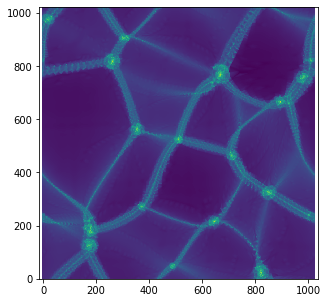

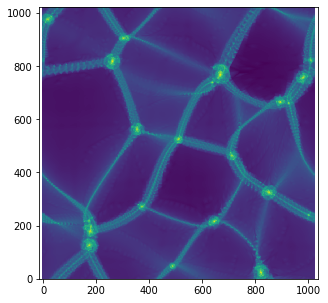

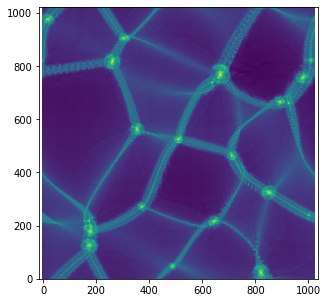

In [7]:
import matplotlib.pyplot as plt

# plt.figure(figsize = (10, 10))
# plt.plot(points[:,0], points[:,1], '.', markersize=0.1)
# plt.xlim([0, L])
# plt.ylim([0, L])
# plt.show()

# plt.figure(figsize = (10, 10))
# plt.triplot(points[:,0], points[:,1], dtfe.delaunay.simplices, linewidth=0.1)
# plt.plot(points[:,0], points[:,1], '.', markersize=0.1)
# plt.xlim([0, L])
# plt.ylim([0, L])
# plt.show()

densPlot(np.log(dens), 5)
densPlot(np.log(GaussianSmooth(dens, 1)), 5)
densPlot(np.log(LogGaussianSmooth(dens, 1)), 5)

# Nexus_den

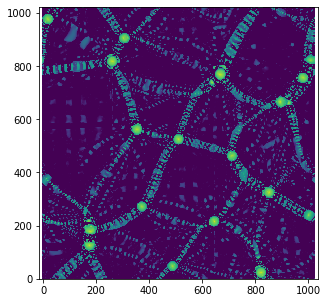

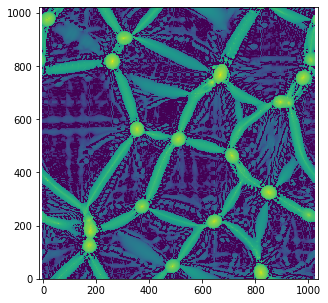

CPU times: user 4.76 s, sys: 1.15 s, total: 5.91 s
Wall time: 28.1 s


(1.5274701480801571, 9.265582008671508)

In [8]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_den(dens, sigma)).compute())
                       ,(2,3,1,0))

classes = np.amax(classes, axis=3)

# np.save("N-body 2D/cluster_Nexus_den",  classes[...,0])
# np.save("N-body 2D/filament_Nexus_den", classes[...,1])

densPlot(np.log(classes[...,0] + 0.00001), 5)
densPlot(np.log(classes[...,1] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens))

# Nexus+

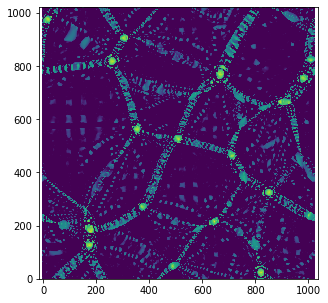

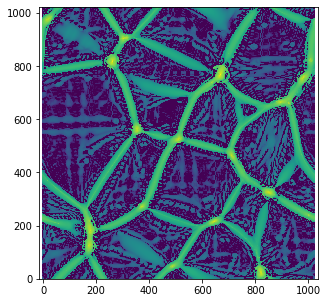

CPU times: user 4.73 s, sys: 1.09 s, total: 5.82 s
Wall time: 27.1 s


(0.3437788522622764, 6.129558511383292)

In [9]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: NexusPlus(dens, sigma)).compute())
                       ,(2,3,1,0))

classes = np.amax(classes, axis=3)

# np.save("N-body 2D/cluster_Nexus+",  classes[...,0])
# np.save("N-body 2D/filament_Nexus+", classes[...,1])

densPlot(np.log(classes[...,0] + 0.00001), 5)
densPlot(np.log(classes[...,1] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens))

# Nexus_tidal

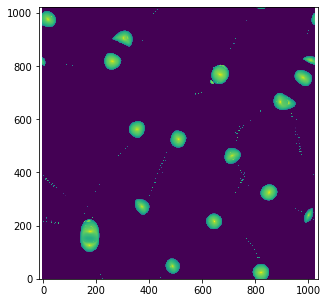

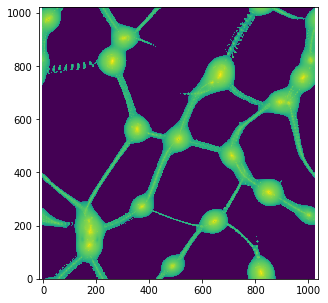

CPU times: user 4.52 s, sys: 1.11 s, total: 5.63 s
Wall time: 28.3 s


(2.0933253082996157, 15.659685051248537)

In [10]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_tidal(dens, sigma)).compute())
                       ,(2,3,1,0))

classes = np.amax(classes, axis=3)

# np.save("N-body 2D/cluster_Nexus_tidal",  classes[...,0])
# np.save("N-body 2D/filament_Nexus_tidal", classes[...,1])

densPlot(np.log(classes[...,0] + 0.00001), 5)
densPlot(np.log(classes[...,1] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens))

# Nexus_denlog

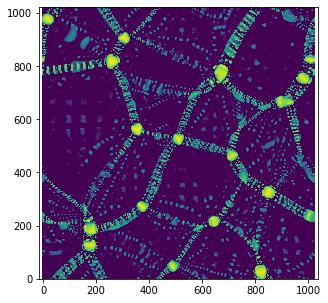

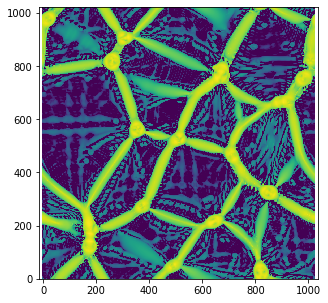

CPU times: user 4.91 s, sys: 1.14 s, total: 6.05 s
Wall time: 26.6 s


(0.06374213611066552, 0.19686361706476213)

In [11]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_den(np.log10(1 + dens), sigma)).compute())
                       ,(2,3,1,0))

classes = np.amax(classes, axis=3)

# np.save("N-body 2D/cluster_Nexus_denlog",  classes[...,0])
# np.save("N-body 2D/filament_Nexus_denlog", classes[...,1])

densPlot(np.log(classes[...,0] + 0.00001), 5)
densPlot(np.log(classes[...,1] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens))

# Nexus_veldiv

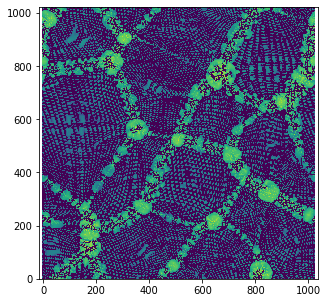

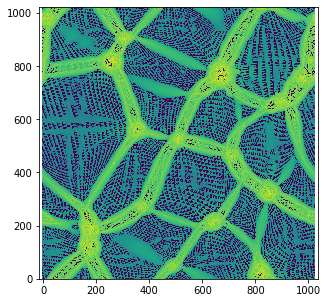

CPU times: user 4.82 s, sys: 1.38 s, total: 6.2 s
Wall time: 28 s


(39.52641506861157, 741.7454506293826)

In [12]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_veldiv(div, sigma)).compute())
                       ,(2,3,1,0))

classes = np.amax(classes, axis=3)

# np.save("N-body 2D/cluster_Nexus_veldiv",  classes[...,0])
# np.save("N-body 2D/filament_Nexus_veldiv", classes[...,1])

densPlot(np.log(classes[...,0] + 0.00001), 5)
densPlot(np.log(classes[...,1] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens))

# Nexus_velshear

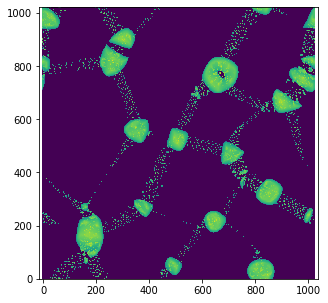

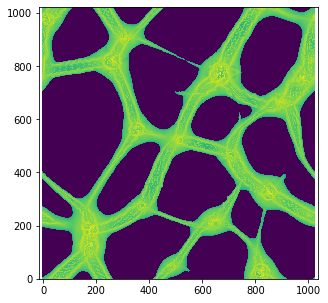

In [ ]:
%%time
import dask.bag as db
bag = db.from_sequence(np.arange(1,20))
classes = np.transpose(
    np.array(bag.map(lambda sigma: Nexus_velshear(div, sigma)).compute())
                       ,(2,3,1,0))

classes = np.amax(classes, axis=3)

# np.save("N-body 2D/cluster_Nexus_velshear",  classes[...,0])
# np.save("N-body 2D/filament_Nexus_velshear", classes[...,1])

densPlot(np.log(classes[...,0] + 0.00001), 5)
densPlot(np.log(classes[...,1] + 0.00001), 5)

(treshold(classes[...,0], dens), treshold(classes[...,1], dens))